In [1]:
from utils import set_seed
import torch
import timm
from data import construct_dataset
from engine import train, evalulate
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import LambdaLR

In [2]:
# to ensure the same effect, we use the same hyper-parameters as the main part of this code.
NUM_CLASSES = 100
LR = 5e-4
WEIGHT_DECAY = 0.05
RANDOM_SEED = 42
NUM_CLIENTS = 10
DATASET_NAME = "CIFAR100"
IID_DEG = 0.5
BATCH_SIZE=64
EPOCHS=50
DEVICE="cuda:1"

In [3]:
set_seed(RANDOM_SEED)

In [4]:
dataset_all_clients = [
    construct_dataset(DATASET_NAME, "./datasets", NUM_CLIENTS, IID_DEG, i)
    for i in range(NUM_CLIENTS)
]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


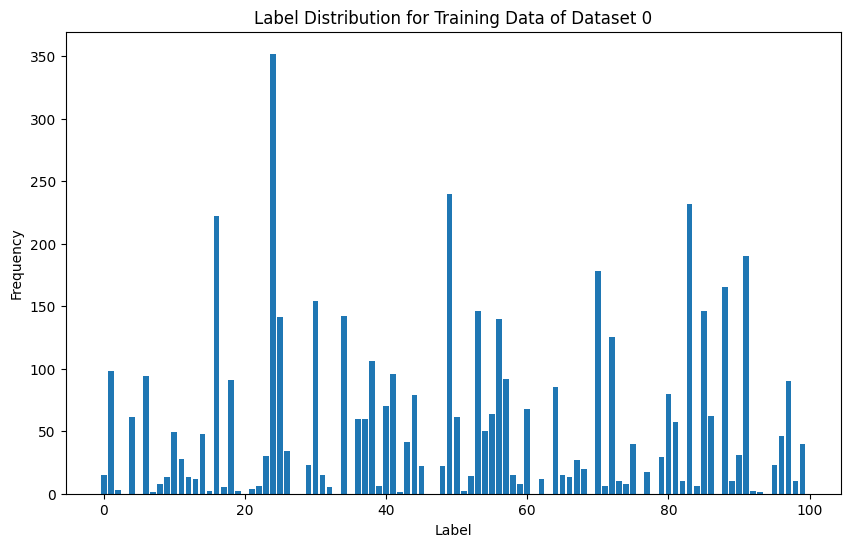

In [5]:
from collections import Counter
import matplotlib.pyplot as plt

# Select the i-th dataset's train_set
i = 0  # Set to desired index (0 <= i < NUM_CLIENTS)
train_set, test_set = dataset_all_clients[i]

# Extract labels from the train_set
labels = [sample[1] for sample in train_set]  # sample[1] represents the target/label

# Count label occurrences
label_counts = Counter(labels)

# Display the distribution as a bar chart
plt.figure(figsize=(10, 6))
plt.bar(label_counts.keys(), label_counts.values())
plt.xlabel("Label")
plt.ylabel("Frequency")
plt.title(f"Label Distribution for Training Data of Dataset {i}")
plt.show()

In [6]:
def load_pretrained_vit(num_classes:int,state_dict_path:str="model_ckpt/vit_small_patch16_224.bin"):
    vit:torch.nn.Module = timm.models.vision_transformer.vit_small_patch16_224(pretrained=False)
    model_state_dict:dict[str,torch.Tensor] = torch.load(state_dict_path,weights_only=True)
    strict=True
    if num_classes != model_state_dict["head.bias"].shape:
        model_state_dict.pop("head.weight")
        model_state_dict.pop("head.bias")
        strict=False
    vit.load_state_dict(model_state_dict,strict=strict)
    return vit

In [7]:
vit_model = load_pretrained_vit(NUM_CLASSES)

for name,param in vit_model.named_parameters():
    print(f"{name}->param.shape:{param.shape}")

cls_token->param.shape:torch.Size([1, 1, 384])
pos_embed->param.shape:torch.Size([1, 197, 384])
patch_embed.proj.weight->param.shape:torch.Size([384, 3, 16, 16])
patch_embed.proj.bias->param.shape:torch.Size([384])
blocks.0.norm1.weight->param.shape:torch.Size([384])
blocks.0.norm1.bias->param.shape:torch.Size([384])
blocks.0.attn.qkv.weight->param.shape:torch.Size([1152, 384])
blocks.0.attn.qkv.bias->param.shape:torch.Size([1152])
blocks.0.attn.proj.weight->param.shape:torch.Size([384, 384])
blocks.0.attn.proj.bias->param.shape:torch.Size([384])
blocks.0.norm2.weight->param.shape:torch.Size([384])
blocks.0.norm2.bias->param.shape:torch.Size([384])
blocks.0.mlp.fc1.weight->param.shape:torch.Size([1536, 384])
blocks.0.mlp.fc1.bias->param.shape:torch.Size([1536])
blocks.0.mlp.fc2.weight->param.shape:torch.Size([384, 1536])
blocks.0.mlp.fc2.bias->param.shape:torch.Size([384])
blocks.1.norm1.weight->param.shape:torch.Size([384])
blocks.1.norm1.bias->param.shape:torch.Size([384])
blocks.1.a

In [ ]:
def get_optimizer_with_lrs(model:timm.models.VisionTransformer, base_lr:float, weight_decay:float, layer_lr_decay=0.8):
    param_groups = []
    
    # Define layers in hierarchical order and decay their learning rates
    layer_names = [
        'patch_embed', 'blocks', 'norm', 'head'
    ]
    
    # Starting with the highest learning rate for the last layers and decay back
    for idx, name in enumerate(layer_names):
        if name == 'blocks':
            # Apply different learning rates to each transformer block
            for block_idx in range(len(model.blocks)):
                block = model.blocks[block_idx]
                lr = base_lr * (layer_lr_decay ** (len(layer_names) - 2 - block_idx))
                
                # Add parameters of each part of the transformer block to param groups
                for sub_name, param in block.named_parameters():
                    param_groups.append({
                        'params': param, 'lr': lr, 'weight_decay': weight_decay
                    })
        else:
            # Apply decay for patch_embed, norm, and head layers
            module = getattr(model, name)
            lr = base_lr * (layer_lr_decay ** (len(layer_names) - idx - 1))
            for param in module.parameters():
                param_groups.append({'params': param, 'lr': lr, 'weight_decay': weight_decay})

    return AdamW(param_groups)

# Define a function for a linear warmup scheduler
def get_linear_scheduler(optimizer, num_warmup_steps, num_training_steps):
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        return max(
            0.0, float(num_training_steps - current_step) / float(max(1, num_training_steps - num_warmup_steps))
        )
    return LambdaLR(optimizer, lr_lambda)

In [ ]:
# Define training tracking storage
training_log = {}

# Training loop for each dataset
for client_id, (train_set, test_set) in enumerate(dataset_all_clients):
    # DataLoaders
    train_loader = DataLoader(train_set, num_workers=4, batch_size=BATCH_SIZE)
    test_loader = DataLoader(test_set, num_workers=4, batch_size=BATCH_SIZE)

    # Load pretrained model and update classification head
    vit_model = load_pretrained_vit(NUM_CLASSES).to(DEVICE)
    
    # Optimizer with layer-wise learning rate decay
    optimizer = AdamW(vit_model.parameters(),lr=LR,weight_decay=WEIGHT_DECAY)
    
    # Scheduler with warmup
    num_training_steps = len(train_loader) * EPOCHS
    scheduler = get_linear_scheduler(optimizer, num_warmup_steps=int(0.1 * num_training_steps), num_training_steps=num_training_steps)
    
    # Loss criterion
    criterion = torch.nn.CrossEntropyLoss()

    # Initialize logging for this dataset
    training_log[client_id] = {'train_loss': [], 'test_loss': [], 'test_metrics': []}

    # Fine-tuning loop
    for ep in range(EPOCHS):
        # Train
        train_loss = train(vit_model, criterion, train_loader, optimizer, 1, DEVICE)
        
        # Evaluate
        test_loss, test_metrics = evalulate(vit_model, test_loader, DEVICE)

        # Step the scheduler
        scheduler.step()

        # Record losses and metrics
        training_log[client_id]['train_loss'].append(train_loss)
        training_log[client_id]['test_loss'].append(test_loss)
        training_log[client_id]['test_metrics'].append(test_metrics)

        # Print logging info
        print(f"Client {client_id} - EPOCH [{ep + 1}/{EPOCHS}] | "
              f"Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Test Metrics: {test_metrics}")

Client 0 - EPOCH [1/50] | Train Loss: 7.4139 | Test Loss: 7.6201 | Test Metrics: {'acc_top5': 0.48828125, 'acc_top1': 0.09765625}
Client 0 - EPOCH [2/50] | Train Loss: 7.1625 | Test Loss: 7.4424 | Test Metrics: {'acc_top5': 1.07421875, 'acc_top1': 0.390625}
Client 0 - EPOCH [3/50] | Train Loss: 6.5107 | Test Loss: 7.0888 | Test Metrics: {'acc_top5': 2.34375, 'acc_top1': 1.171875}
Client 0 - EPOCH [4/50] | Train Loss: 5.4770 | Test Loss: 6.5655 | Test Metrics: {'acc_top5': 7.51953125, 'acc_top1': 2.9296875}
Client 0 - EPOCH [5/50] | Train Loss: 4.5997 | Test Loss: 6.1980 | Test Metrics: {'acc_top5': 9.8828125, 'acc_top1': 4.1015625}
Client 0 - EPOCH [6/50] | Train Loss: 4.0275 | Test Loss: 5.9317 | Test Metrics: {'acc_top5': 13.65234375, 'acc_top1': 5.4296875}
Client 0 - EPOCH [7/50] | Train Loss: 3.5576 | Test Loss: 5.6925 | Test Metrics: {'acc_top5': 18.10546875, 'acc_top1': 7.63671875}
Client 0 - EPOCH [8/50] | Train Loss: 3.1380 | Test Loss: 5.4443 | Test Metrics: {'acc_top5': 22.51

In [ ]:
import pandas as pd

# Prepare a list to hold the structured data for the DataFrame
results = []

# Populate the list with each client's results
for client_id, logs in training_log.items():
    for epoch in range(EPOCHS):
        results.append({
            'client_id': client_id,
            'epoch': epoch + 1,
            'train_loss': logs['train_loss'][epoch],
            'test_loss': logs['test_loss'][epoch],
            'test_metrics': logs['test_metrics'][epoch]
        })

# Convert the list of dictionaries into a DataFrame
results_df = pd.DataFrame(results)

# Optionally, save the DataFrame to a CSV file
results_df.to_csv("training_results.csv", index=False)
